In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from scipy.optimize import linprog

In [3]:
os.chdir(r"C:\Users\jakes\OneDrive\Documents\staffing-forecast-optimization\data")
os.getcwd()

'C:\\Users\\jakes\\OneDrive\\Documents\\staffing-forecast-optimization\\data'

In [5]:
df_hourly = pd.read_csv("hour.csv")

In [7]:
print(df_hourly.head())

   instant      dteday  season  yr  mnth  hr  holiday  weekday  workingday  \
0        1  2011-01-01       1   0     1   0        0        6           0   
1        2  2011-01-01       1   0     1   1        0        6           0   
2        3  2011-01-01       1   0     1   2        0        6           0   
3        4  2011-01-01       1   0     1   3        0        6           0   
4        5  2011-01-01       1   0     1   4        0        6           0   

   weathersit  temp   atemp   hum  windspeed  casual  registered  cnt  
0           1  0.24  0.2879  0.81        0.0       3          13   16  
1           1  0.22  0.2727  0.80        0.0       8          32   40  
2           1  0.22  0.2727  0.80        0.0       5          27   32  
3           1  0.24  0.2879  0.75        0.0       3          10   13  
4           1  0.24  0.2879  0.75        0.0       0           1    1  


In [9]:
# Gathering mean values per hour of day representing demand
# Done using total number of bikes rented (registered + casual)
hour_labels = [f"{h%12 if h%12 !=0 else 12}{'AM' if h<12 else 'PM'}" for h in range(24)]
hourly_demand = df_hourly.groupby("hr")["cnt"].mean()
hourly_demand.index = hour_labels
print(hourly_demand)

12AM     53.898072
1AM      33.375691
2AM      22.869930
3AM      11.727403
4AM       6.352941
5AM      19.889819
6AM      76.044138
7AM     212.064649
8AM     359.011004
9AM     219.309491
10AM    173.668501
11AM    208.143054
12PM    253.315934
1PM     253.661180
2PM     240.949246
3PM     251.233196
4PM     311.983562
5PM     461.452055
6PM     425.510989
7PM     311.523352
8PM     226.030220
9PM     172.314560
10PM    131.335165
11PM     87.831044
Name: cnt, dtype: float64


In [11]:
# Estimating a reasonable capacity for the LP
# Done by taking the average number of registered users per day
capacity_using_registered_users = df_hourly.groupby("hr")["registered"].mean()
capacity_using_registered_users.index = hour_labels
capacity_registered = int(capacity_using_registered_users.sum())
print(f"Suggested starting capacity for LP: {capacity_registered}")
print(capacity_using_registered_users)

Suggested starting capacity for LP: 3671
12AM     43.739669
1AM      26.871547
2AM      18.097902
3AM       9.011478
4AM       5.098996
5AM      18.478382
6AM      71.882759
7AM     201.009629
8AM     337.331499
9AM     188.418157
10AM    127.191197
11AM    148.602476
12PM    185.021978
1PM     181.352538
2PM     165.381344
3PM     176.327846
4PM     238.238356
5PM     387.178082
6PM     364.390110
7PM     262.752747
8PM     189.796703
9PM     144.059066
10PM    109.082418
11PM     72.631868
Name: registered, dtype: float64


In [13]:
# Defining LP
demand = hourly_demand
n = len(demand)

# Objective: max sum(y_h) --> min - sum(y_h)
c = np.concatenate([np.zeros(n), -np.ones(n)])

# Constraints
A = []
b = []

# y_h <= x_h

for i in range(n):
    row = np.zeros(2*n)
    row[i] = -1
    row[i+n] = 1
    A.append(row)
    b.append(0)

# y_h <= demand_h

for i in range(n):
    row = np.zeros(2*n)
    row[i+n] = 1
    A.append(row)
    b.append(demand[i])

# sum x_h <= capacity

row = np.zeros(2*n)
row[:n] = 1
A.append(row)
b.append(capacity_registered)

bounds = [(0, None)] * (2*n)

res = linprog(c, A_ub =A, b_ub=b, bounds=bounds)

# Interpreting Results

x_opt = res.x[:n]
y_opt = res.x[n:]

# print(x_opt_smooth)
# print(y_opt_smooth)

proportion = hourly_demand / hourly_demand.sum()
x_opt_smooth = capacity_registered * proportion
y_opt_smooth = np.minimum(x_opt_smooth, hourly_demand)

C:\Users\jakes\AppData\Local\Temp\ipykernel_9440\3794013577.py:27: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b.append(demand[i])


In [15]:
# Check to make sure results make sense

print("Total allocated bikes", x_opt_smooth.sum())
print("Total fulfilled rentals", y_opt_smooth.sum())
print("Any y_h > x_h?" , any(y_opt_smooth > x_opt_smooth))
print("Any y_h > demand_h?", any(y_opt_smooth > demand))

Total allocated bikes 3671.0
Total fulfilled rentals 3671.0
Any y_h > x_h? False
Any y_h > demand_h? False


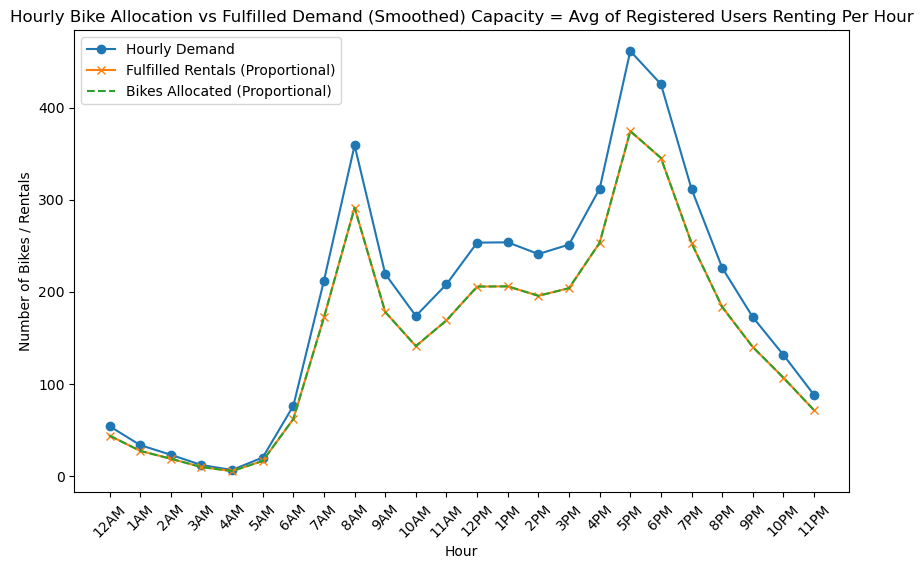

In [21]:
plt.figure(figsize=(10,6))
plt.plot(range(24), demand, label = "Hourly Demand", marker = 'o')
plt.plot(range(24), y_opt_smooth, label = "Fulfilled Rentals (Proportional)", marker = 'x')
plt.plot(range(24), x_opt_smooth, label = "Bikes Allocated (Proportional)", linestyle ='--')
plt.xticks(range(24), hour_labels, rotation=45)
plt.xlabel("Hour")
plt.ylabel("Number of Bikes / Rentals")
plt.title("Hourly Bike Allocation vs Fulfilled Demand (Smoothed) Capacity = Avg of Registered Users Renting Per Hour")
plt.legend()
plt.show()

In [85]:
# Scenario Testing for Capacity +- 10% and 20% of registered users

# +10%
capacity_registered_plus_10_precent = int(capacity_using_registered_users.sum()) * 1.1
# + 20%
capacity_registered_plus_20_precent = int(capacity_using_registered_users.sum()) * 1.2

# + 30%
capacity_registered_plus_30_precent = int(capacity_using_registered_users.sum()) * 1.3

# + 40%
capacity_registered_plus_40_precent = int(capacity_using_registered_users.sum()) * 1.4

# + 50%
capacity_registered_plus_50_precent = int(capacity_using_registered_users.sum()) * 1.5

# - 10%
capacity_registered_minus_10_precent = int(capacity_using_registered_users.sum()) * 0.9

# -20%
capacity_registered_minus_20_precent = int(capacity_using_registered_users.sum()) * 0.8


In [41]:
# Defining LP as a function based on capacity

def capacity_changing_LP(capacity):
    demand = hourly_demand
    n = len(demand)

    # Objective: max sum(y_h) --> min - sum(y_h)
    c = np.concatenate([np.zeros(n), -np.ones(n)])

    # Constraints
    A = []
    b = []

    # y_h <= x_h

    for i in range(n):
        row = np.zeros(2*n)
        row[i] = -1
        row[i+n] = 1
        A.append(row)
        b.append(0)

    # y_h <= demand_h

    for i in range(n):
        row = np.zeros(2*n)
        row[i+n] = 1
        A.append(row)
        b.append(demand[i])

    # sum x_h <= capacity
    row = np.zeros(2*n)
    row[:n] = 1
    A.append(row)
    b.append(capacity)

    bounds = [(0, None)] * (2*n)

    res = linprog(c, A_ub =A, b_ub=b, bounds=bounds)

    # Interpreting Results

    x_opt = res.x[:n]
    y_opt = res.x[n:]

    # print(x_opt_smooth)
    # print(y_opt_smooth)

    proportion = hourly_demand / hourly_demand.sum()
    x_opt_smooth = capacity * proportion
    y_opt_smooth = np.minimum(x_opt_smooth, hourly_demand)
    return y_opt



C:\Users\jakes\AppData\Local\Temp\ipykernel_9440\439749243.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b.append(demand[i])


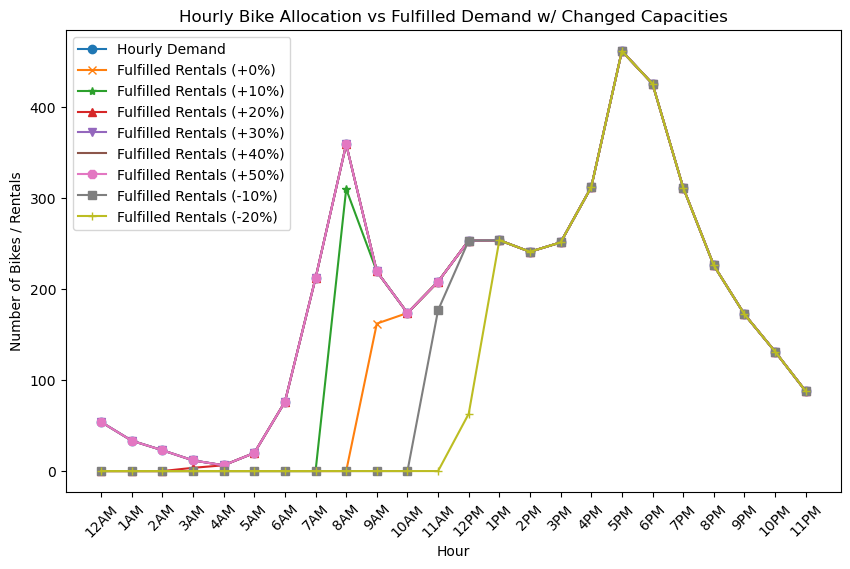

In [87]:
# Plotting all different capacities

plt.figure(figsize=(10,6))
plt.plot(range(24), demand, label = "Hourly Demand", marker = 'o')
plt.plot(range(24), y_opt, label = "Fulfilled Rentals (+0%)", marker = 'x')
plt.plot(range(24), capacity_changing_LP(capacity_registered_plus_10_precent), label = "Fulfilled Rentals (+10%)", marker = '*')
plt.plot(range(24), capacity_changing_LP(capacity_registered_plus_20_precent), label = "Fulfilled Rentals (+20%)", marker = '^')
plt.plot(range(24), capacity_changing_LP(capacity_registered_plus_30_precent), label = "Fulfilled Rentals (+30%)", marker = 'v')
plt.plot(range(24), capacity_changing_LP(capacity_registered_plus_40_precent), label = "Fulfilled Rentals (+40%)", marker = ',')
plt.plot(range(24), capacity_changing_LP(capacity_registered_plus_50_precent), label = "Fulfilled Rentals (+50%)", marker = '8')
plt.plot(range(24), capacity_changing_LP(capacity_registered_minus_10_precent), label = "Fulfilled Rentals (-10%)", marker ='s')
plt.plot(range(24), capacity_changing_LP(capacity_registered_minus_20_precent), label = "Fulfilled Rentals (-20%)", marker = '+')
plt.xticks(range(24), hour_labels, rotation=45)
plt.xlabel("Hour")
plt.ylabel("Number of Bikes / Rentals")
plt.title("Hourly Bike Allocation vs Fulfilled Demand w/ Changed Capacities")
plt.legend()
plt.show()

In [93]:
# Defining the capacites

capacities = [
    capacity_registered_minus_20_precent,
    capacity_registered_minus_10_precent,
    int(capacity_using_registered_users.sum()),
    capacity_registered_plus_10_precent,
    capacity_registered_plus_20_precent,
    capacity_registered_plus_30_precent,
    capacity_registered_plus_40_precent,
    capacity_registered_plus_50_precent
]

capacity_labels = ["-20%", "-10%", "Mean Registered Users", "+10%", "+20%", "+30%", "+40%", "+50%"]



        

In [95]:
# Creating a heatmap of capacity changing data

heatmap_data = pd.DataFrame(
    index = capacity_labels,
    columns = range(24)
)

for label, cap in zip(capacity_labels, capacities):
    heatmap_data.loc[label] = capacity_changing_LP(cap)

# Converting fulfilled to % of demand fulfilled

utilization_data = heatmap_data.copy()

for h in range(24):
    utilization_data.iloc[:, h] = (utilization_data.iloc[:,h] / hourly_demand[h])




C:\Users\jakes\AppData\Local\Temp\ipykernel_9440\439749243.py:29: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  b.append(demand[i])
C:\Users\jakes\AppData\Local\Temp\ipykernel_9440\425472329.py:16: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  utilization_data.iloc[:, h] = (utilization_data.iloc[:,h] / hourly_demand[h])


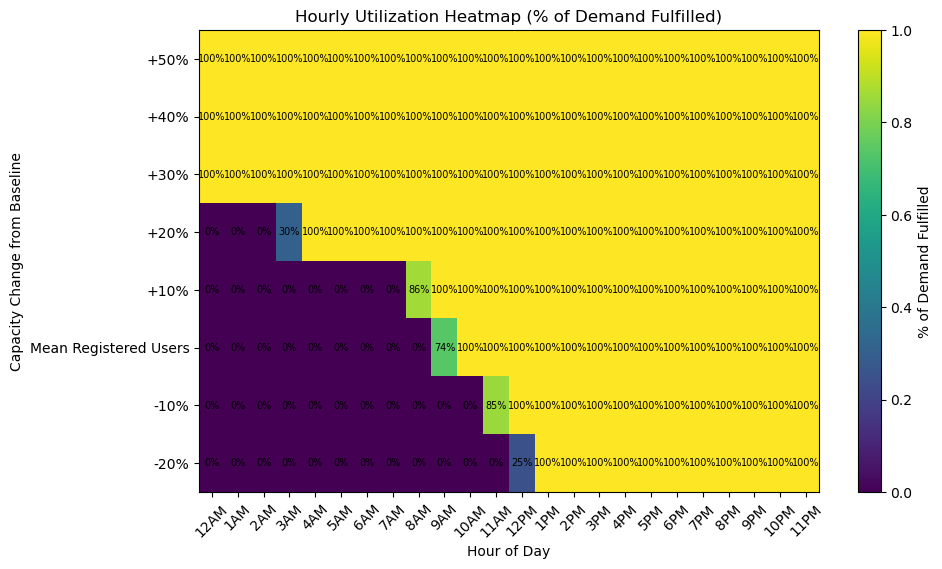

In [105]:
# Plotting Heatmap

utilization_data = np.array(utilization_data, dtype = float)
plt.figure(figsize=(10,6))
plt.imshow(
    utilization_data,
    aspect = "auto",
    origin = "lower",
    vmin = 0,
    vmax = 1
)

cbar = plt.colorbar()
cbar.set_label("% of Demand Fulfilled")

plt.xticks(range(24), hour_labels, rotation = 45)
plt.yticks(range(len(capacity_labels)), capacity_labels)
plt.xlabel("Hour of Day")
plt.ylabel("Capacity Change from Baseline")
plt.title("Hourly Utilization Heatmap (% of Demand Fulfilled)")

for i in range(len(capacity_labels)):
    for j in range(24):
        value = utilization_data[i,j]
        plt.text(
            j,i,
            f"{value:.0%}",
            ha = "center",
            va = "center",
            fontsize = 7)

plt.show()

In [107]:
# Acknowledging that the way that the previous LP allocated the LP was changed (changes can be viewed in day_3_plan markdown)

def bike_reuse_update(demand, capacity):
    n = len(demand)
    c = -np.ones(n) # Max fulfilled demand

    # bounds: y_h >= 0, y_h <= demand_h
    bounds = [(0, dh) for dh in demand]

    # Availability constraints
    A = []
    b = []

    # simulate availability as upper bound constraints per hour
    for i in range(n):
        row = np.zeros(n)
        row[:i+1] = 1
        A.append(row)
        b.append(capacity)

    res = linprog(c, A_ub=A, b_ub=b, bounds=bounds)
    y_opt = res.x
    return y_opt

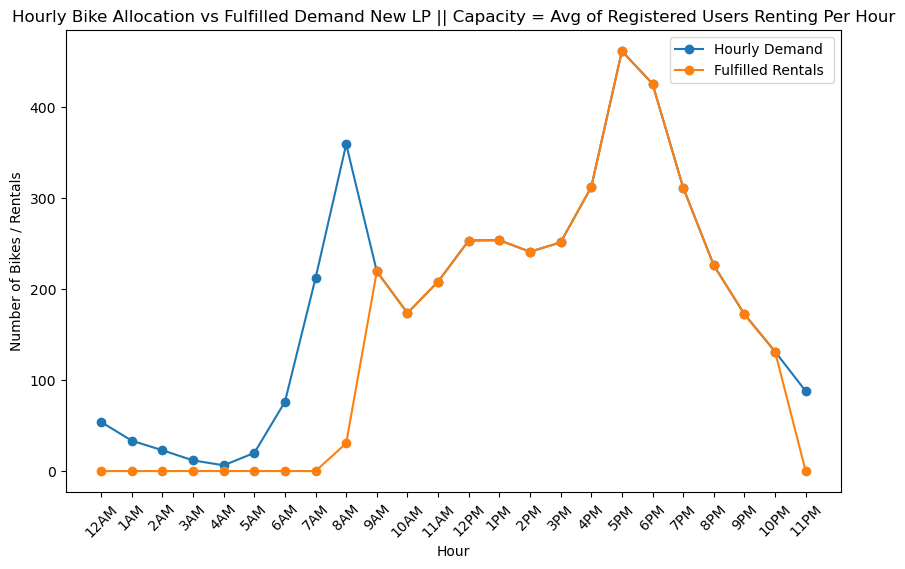

In [115]:
# Simple Line Plot of new LP

plt.figure(figsize=(10,6))
plt.plot(range(24), hourly_demand, label = "Hourly Demand", marker = 'o')
plt.plot(range(24), bike_reuse_update(hourly_demand,capacity_registered), label = "Fulfilled Rentals ", marker = 'o')
plt.xticks(range(24), hour_labels, rotation=45)
plt.xlabel("Hour")
plt.ylabel("Number of Bikes / Rentals")
plt.title("Hourly Bike Allocation vs Fulfilled Demand New LP || Capacity = Avg of Registered Users Renting Per Hour")
plt.legend()
plt.show()

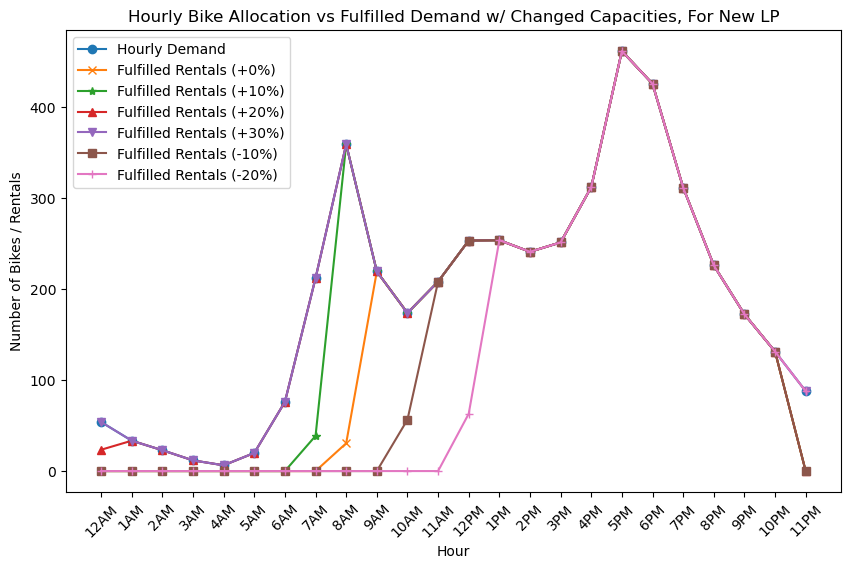

In [129]:
# Adding in all different capacity usages

plt.figure(figsize=(10,6))
plt.plot(range(24), demand, label = "Hourly Demand", marker = 'o')
plt.plot(range(24), bike_reuse_update(hourly_demand,capacity_registered), label = "Fulfilled Rentals (+0%) ", marker = 'x')
plt.plot(range(24), bike_reuse_update(hourly_demand,capacity_registered_plus_10_precent), label = "Fulfilled Rentals (+10%)", marker = '*')
plt.plot(range(24), bike_reuse_update(hourly_demand,capacity_registered_plus_20_precent), label = "Fulfilled Rentals (+20%)", marker = '^')
plt.plot(range(24), bike_reuse_update(hourly_demand,capacity_registered_plus_30_precent), label = "Fulfilled Rentals (+30%)", marker = 'v')
plt.plot(range(24), bike_reuse_update(hourly_demand,capacity_registered_minus_10_precent), label = "Fulfilled Rentals (-10%)", marker ='s')
plt.plot(range(24), bike_reuse_update(hourly_demand,capacity_registered_minus_20_precent), label = "Fulfilled Rentals (-20%)", marker = '+')
plt.xticks(range(24), hour_labels, rotation=45)
plt.xlabel("Hour")
plt.ylabel("Number of Bikes / Rentals")
plt.title("Hourly Bike Allocation vs Fulfilled Demand w/ Changed Capacities, For New LP")
plt.legend()
plt.show()